Now that we have our hatsTrees that have the interesting physical variables calculated, let's do some analysis with them. To combine our MC background samples, we will need to compute weights for them. Fortunately, we have these defined in python `.ini` files.

`.ini` files are a standard format for python configuration files. They have a simple syntax and are quite flexible -- this is another example of where python can help us from falling in the trap of re-inventing the wheel by writing custom code for every simple task, like parsing text files.

Let's take a look at `hatsConfig.ini`.

In [1]:
!cat hatsConfig.ini

[hatsXsects]       #      (pb)
QCD_HT300to500     :   347700.00     
QCD_HT500to700     :    32100.00      
QCD_HT700to1000    :     6831.00       
QCD_HT1000to1500   :     1207.00       
QCD_HT1500to2000   :      119.90      
QCD_HT2000toInf    :       25.24      

[hatsNprocessed]   #  (# processed)
QCD_HT300to500     :     4920846
QCD_HT500to700     :     3845821
QCD_HT700to1000    :     1959216
QCD_HT1000to1500   :    16813667
QCD_HT1500to2000   :    19186048
QCD_HT2000toInf    :    15486719


In [2]:
from ConfigParser import RawConfigParser
config = RawConfigParser()   
config.optionxform = str       # Last two lines are done because ConfigParser will not preserve case
config.read("hatsConfig.ini")

['hatsConfig.ini']

Here is a nifty way to create a dict of the cross sections and number of events:

In [3]:
crossSections = dict([sample, float(xsec)] for sample, xsec in config.items('hatsXsects'))
nProcessed    = dict([sample, int(nPro)] for sample, nPro in config.items('hatsNprocessed'))

from pprint import pprint
print "cross sections:" 
pprint(crossSections)
print "number of events processed:"
pprint(nProcessed)

cross sections:
{'QCD_HT1000to1500': 1207.0,
 'QCD_HT1500to2000': 119.9,
 'QCD_HT2000toInf': 25.24,
 'QCD_HT300to500': 347700.0,
 'QCD_HT500to700': 32100.0,
 'QCD_HT700to1000': 6831.0}
number of events processed:
{'QCD_HT1000to1500': 16813667,
 'QCD_HT1500to2000': 19186048,
 'QCD_HT2000toInf': 15486719,
 'QCD_HT300to500': 4920846,
 'QCD_HT500to700': 3845821,
 'QCD_HT700to1000': 1959216}


python `dict`s are extremely useful, because we can give descriptive names to the data they hold. Let's use our dicts to calculate the weights for our MC background samples.

In [4]:
weights = {}
luminosity = 1.42    # This is just an example value
for sample in crossSections.keys():
    weights[sample] = luminosity * crossSections[sample]/nProcessed[sample]
pprint(weights)

{'QCD_HT1000to1500': 0.00010193731087929836,
 'QCD_HT1500to2000': 8.874052644921978e-06,
 'QCD_HT2000toInf': 2.314292652949924e-06,
 'QCD_HT300to500': 0.1003351862667517,
 'QCD_HT500to700': 0.011852345701997051,
 'QCD_HT700to1000': 0.004950970183991963}


Now we will use the Python XRootD bindings to access all of our input files. Since our input files live on eos, we follow the recommendations on uscms.org/uscms_at_work/computing/LPC/usingEOSAtLPC.shtml, which instructs us to always list and open files via XRootD. First, we can use the Python XRootD files to look at our input directory, as we did in firstLook.ipynb using shell commands.

In [5]:
from XRootD import client
xrdClient = client.FileSystem("root://cmseos.fnal.gov//")
hatsTreesDir = "//store/user/hats/PyRoot/2017/hatsDijetTrees"
status, dirList = xrdClient.dirlist(hatsTreesDir)
for entry in dirList:
    print "file host:", entry.hostaddr, "  file name:", entry.name

file host: cmseos.fnal.gov:1094   file name: hatsTrees_QCD_HT1000to1500
file host: cmseos.fnal.gov:1094   file name: hatsTrees_QCD_HT1500to2000
file host: cmseos.fnal.gov:1094   file name: hatsTrees_QCD_HT2000toInf
file host: cmseos.fnal.gov:1094   file name: hatsTrees_QCD_HT200to300
file host: cmseos.fnal.gov:1094   file name: hatsTrees_QCD_HT300to500
file host: cmseos.fnal.gov:1094   file name: hatsTrees_QCD_HT500to700
file host: cmseos.fnal.gov:1094   file name: hatsTrees_QCD_HT700to1000
file host: cmseos.fnal.gov:1094   file name: hatsTrees_data
file host: cmseos.fnal.gov:1094   file name: hatsTrees_sig


For ROOT to open the input file, it will want a full url in the form `root://host:port//the/location/on/eos/file.root`. So we can make a dict to store what we need to build a full url, using a clever list comprehension. In the dict, we will store a tuple that separates out the logical filename from the rest of the full url.

In [6]:
from os import path
sampleDirURLs = {}
for sample in crossSections.keys():
    [matchingDir] = [("root://" + entry.hostaddr, path.join(hatsTreesDir, entry.name)) for entry in dirList if sample in entry.name]
    sampleDirURLs[sample]=matchingDir  
pprint(sampleDirURLs)

{'QCD_HT1000to1500': ('root://cmseos.fnal.gov:1094',
                      '//store/user/hats/PyRoot/2017/hatsDijetTrees/hatsTrees_QCD_HT1000to1500'),
 'QCD_HT1500to2000': ('root://cmseos.fnal.gov:1094',
                      '//store/user/hats/PyRoot/2017/hatsDijetTrees/hatsTrees_QCD_HT1500to2000'),
 'QCD_HT2000toInf': ('root://cmseos.fnal.gov:1094',
                     '//store/user/hats/PyRoot/2017/hatsDijetTrees/hatsTrees_QCD_HT2000toInf'),
 'QCD_HT300to500': ('root://cmseos.fnal.gov:1094',
                    '//store/user/hats/PyRoot/2017/hatsDijetTrees/hatsTrees_QCD_HT300to500'),
 'QCD_HT500to700': ('root://cmseos.fnal.gov:1094',
                    '//store/user/hats/PyRoot/2017/hatsDijetTrees/hatsTrees_QCD_HT500to700'),
 'QCD_HT700to1000': ('root://cmseos.fnal.gov:1094',
                     '//store/user/hats/PyRoot/2017/hatsDijetTrees/hatsTrees_QCD_HT700to1000')}


We can make dicts to hold TChains of all our data, and then draw them with weights. Also in this cell, we use the Python bindings for XRootD to generate our list of input files.

In [7]:
hatsChains = {}
import ROOT as r
r.gDebug = 1
for sample in crossSections.keys():
    chain = r.TChain('hatsDijets')
    status, fileList = xrdClient.dirlist(sampleDirURLs[sample][1]) # dirlist takes the logical filename
    for hatsFile in fileList:
        # temporarily disabled on May 29, 2020 to get around some xrootd issues
        #chain.Add(sampleDirURLs[sample][0] + path.join(sampleDirURLs[sample][1], hatsFile.name))  # ROOT takes the full url
        # Temporary work around for the day of the HATS
        chain.Add("/home/hats/2020/pyroot/" + path.join(sampleDirURLs[sample][1], hatsFile.name))  # ROOT takes the full url
    hatsChains[sample] = chain
pprint(hatsChains)

Welcome to JupyROOT 6.14/09
{'QCD_HT1000to1500': <ROOT.TChain object ("hatsDijets") at 0x5534e90>,
 'QCD_HT1500to2000': <ROOT.TChain object ("hatsDijets") at 0x5517910>,
 'QCD_HT2000toInf': <ROOT.TChain object ("hatsDijets") at 0x5535ab0>,
 'QCD_HT300to500': <ROOT.TChain object ("hatsDijets") at 0x54d1e60>,
 'QCD_HT500to700': <ROOT.TChain object ("hatsDijets") at 0x5523b30>,
 'QCD_HT700to1000': <ROOT.TChain object ("hatsDijets") at 0x5533a70>}


Now we can try to make weighted histograms of all the MC backgrounds using TChain.Draw(), and put them into a stackplot. Here we run into a classic pyROOT gotcha: it's not easy to prevent root from garbage collecting your histograms. It's best to keep them in a list or dict that isn't within the scope of a loop.

In [8]:
onechain = hatsChains['QCD_HT1000to1500']
for chain in hatsChains:
    print "%s: %s" % (chain, len(hatsChains[chain].GetListOfFiles()))

QCD_HT500to700: 16
QCD_HT700to1000: 12
QCD_HT1000to1500: 4
QCD_HT1500to2000: 4
QCD_HT2000toInf: 4
QCD_HT300to500: 12
TClass::GetClass: Header Parsing - The representation of gGeoManager was not found in the type system. A lookup in the interpreter is about to be tried: this can cause parsing. This can be avoided selecting gGeoManager in the linkdef/selection file.
TEnum::GetEnum: Header Parsing - The enumerator gGeoManager is not known to the typesystem: an interpreter lookup will be performed. This can imply parsing of headers. This can be avoided selecting the numerator in the linkdef/selection file.
TClass::GetClass: Header Parsing - The representation of ROOT::gGeoManager was not found in the type system. A lookup in the interpreter is about to be tried: this can cause parsing. This can be avoided selecting ROOT::gGeoManager in the linkdef/selection file.
TEnum::GetEnum: Header Parsing - The enumerator ROOT::gGeoManager is not known to the typesystem: an interpreter lookup will be 

Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TObjArray: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TObjArray: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TObjArray: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TObjArray: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TObjArray: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TObjArray: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TObjArray: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TObjArray: this can involve p

In [9]:
hists = {}
import sys
for sample in crossSections.keys():
    varNames=[]
    sys.stderr.write("Sample: %s\n" % sample)
    for var in hatsChains[sample].GetListOfBranches():
        varNames.append(var.GetName())
    for varName in varNames:
        sys.stderr.write("  varName: %s\n" % varName)
        histLabel = "%s_%s" % (varName, sample)
        hists[histLabel]=r.TH1F(histLabel, histLabel, 100, 0, 0)
        hatsChains[sample].Draw("%s>>%s" % (varName, histLabel))

pprint(hists)

Sample: QCD_HT500to700
  varName: leadingEta
  varName: subleadingEta
  varName: cosThetaStar
  varName: dijetEtBalance
  varName: dijetMass
Sample: QCD_HT700to1000
  varName: leadingEta
  varName: subleadingEta
  varName: cosThetaStar
  varName: dijetEtBalance
  varName: dijetMass
Sample: QCD_HT1000to1500
  varName: leadingEta
  varName: subleadingEta
  varName: cosThetaStar
  varName: dijetEtBalance
  varName: dijetMass
Sample: QCD_HT1500to2000
  varName: leadingEta
  varName: subleadingEta
  varName: cosThetaStar
  varName: dijetEtBalance
  varName: dijetMass
Sample: QCD_HT2000toInf
  varName: leadingEta
  varName: subleadingEta
  varName: cosThetaStar
  varName: dijetEtBalance


{'cosThetaStar_QCD_HT1000to1500': <ROOT.TH1F object ("cosThetaStar_QCD_HT1000to1500") at 0x681eab0>,
 'cosThetaStar_QCD_HT1500to2000': <ROOT.TH1F object ("cosThetaStar_QCD_HT1500to2000") at 0x688adf0>,
 'cosThetaStar_QCD_HT2000toInf': <ROOT.TH1F object ("cosThetaStar_QCD_HT2000toInf") at 0x5b9a910>,
 'cosThetaStar_QCD_HT300to500': <ROOT.TH1F object ("cosThetaStar_QCD_HT300to500") at 0x5b9f1e0>,
 'cosThetaStar_QCD_HT500to700': <ROOT.TH1F object ("cosThetaStar_QCD_HT500to700") at 0x6885230>,
 'cosThetaStar_QCD_HT700to1000': <ROOT.TH1F object ("cosThetaStar_QCD_HT700to1000") at 0x68000b0>,
 'dijetEtBalance_QCD_HT1000to1500': <ROOT.TH1F object ("dijetEtBalance_QCD_HT1000to1500") at 0x68754d0>,
 'dijetEtBalance_QCD_HT1500to2000': <ROOT.TH1F object ("dijetEtBalance_QCD_HT1500to2000") at 0x5b6ee80>,
 'dijetEtBalance_QCD_HT2000toInf': <ROOT.TH1F object ("dijetEtBalance_QCD_HT2000toInf") at 0x5bbdbb0>,
 'dijetEtBalance_QCD_HT300to500': <ROOT.TH1F object ("dijetEtBalance_QCD_HT300to500") at 0x5b

  varName: dijetMass
Sample: QCD_HT300to500
  varName: leadingEta
  varName: subleadingEta
  varName: cosThetaStar
  varName: dijetEtBalance
  varName: dijetMass
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TBranch: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TBranch: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TBranch: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TBranch: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TBranch: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TBranch: this can involve parsing.
Info in <TClass::GetListOfMethods>: Header Parsing - Asking for all the methods of class TBran

Now that we've made histograms of all our variables in all our samples, we can put together stack plots of them all. We will leave that as an exercise to work on for the rest of the HATS. The histograms are organized in a dictionary that you should be able to navigate easily using their keys.

TEnum::GetEnum: Header Parsing - The enumerator TPad::(anonymous) is not known to the typesystem: an interpreter lookup will be performed. This can imply parsing of headers. This can be avoided selecting the numerator in the linkdef/selection file.
TEnum::GetEnum: Header Parsing - The enumerator TPad::(anonymous) is not known to the typesystem: an interpreter lookup will be performed. This can imply parsing of headers. This can be avoided selecting the numerator in the linkdef/selection file.
TEnum::GetEnum: Header Parsing - The enumerator TPad::(anonymous) is not known to the typesystem: an interpreter lookup will be performed. This can imply parsing of headers. This can be avoided selecting the numerator in the linkdef/selection file.
TEnum::GetEnum: Header Parsing - The enumerator TPad::(anonymous) is not known to the typesystem: an interpreter lookup will be performed. This can imply parsing of headers. This can be avoided selecting the numerator in the linkdef/selection file.
TEnu

Info in <TPluginManager::LoadHandlerMacros>: /cvmfs/cms.cern.ch/slc7_amd64_gcc820/lcg/root/6.14.09/etc/plugins/TVirtualHistPainter
Info in <TPluginManager::FindHandler>: found plugin for THistPainter
Info in <TUnixSystem::Load>: loaded library /cvmfs/cms.cern.ch/slc7_amd64_gcc820/lcg/root/6.14.09/lib/libHistPainter.so, status 0
Info in <TInterpreter::TCling::AutoLoad>: loaded library libHistPainter.so for THistPainter
Info in <TPluginManager::LoadHandlerMacros>: /cvmfs/cms.cern.ch/slc7_amd64_gcc820/lcg/root/6.14.09/etc/plugins/TVirtualGraphPainter
Info in <TPluginManager::FindHandler>: found plugin for TGraphPainter


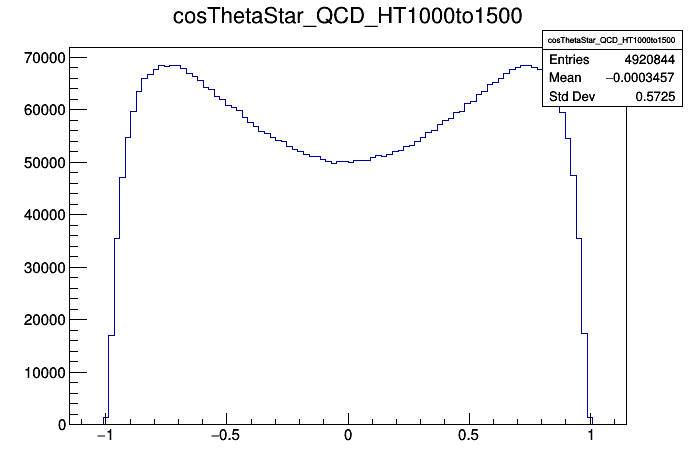

In [10]:
canvas = r.TCanvas()
hists["cosThetaStar_QCD_HT1000to1500"].Draw()
canvas.Draw()